In [2]:
import pandas as pd
deneme = pd.read_csv('EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv')
deneme

,Gmt time,open,high,low,close,volume
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083
...,...,...,...,...,...,...
28855,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.6300
28856,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.6600
28857,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.3300
28858,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.5300


In [3]:
# volume u 0 olan değerleri çıkartalım

indexZeros = deneme[deneme['volume'] == 0].index
deneme.drop(indexZeros, inplace=True)
deneme.loc[(deneme['volume'] == 0)]

,Gmt time,open,high,low,close,volume


Herhangi Bir Null Value Olmadığını Kontrol Edelim

In [4]:
deneme.isna().sum()

Gmt time    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [5]:
import numpy as np
import pandas_ta as ta
#deneme.ta.indicators
#help(ta.atr)

deneme['ATTR'] = deneme.ta.atr(length=20)
deneme['RSI'] = deneme.ta.rsi()
deneme['Average'] = deneme.ta.midprice(length=1)
deneme['MA40'] = deneme.ta.sma(lenght=40)
deneme['MA80'] = deneme.ta.sma(lenght=80)
deneme['MA160'] = deneme.ta.sma(lenght=160)

from scipy.stats import linregress

def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

deneme['slopeMA40'] = deneme['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
deneme['slopeMA80'] = deneme['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
deneme['slopeMA160'] = deneme['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
deneme['AverageSlope'] = deneme['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
deneme['RSISlope'] = deneme['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)



In [6]:
deneme.tail()

,Gmt time,open,high,low,close,volume,ATTR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
28855,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001947,59.946065,1.160290,1.159742,1.159742,1.159742,0.000510,0.000510,0.000510,-0.000162,-1.237279
28856,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001947,58.038673,1.160920,1.159996,1.159996,1.159996,0.000452,0.000452,0.000452,0.000035,-0.095942
28857,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.001965,53.777344,1.160080,1.159963,1.159963,1.159963,0.000371,0.000371,0.000371,0.000233,0.033494
28858,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.001972,54.744468,1.159980,1.159924,1.159924,1.159924,0.000255,0.000255,0.000255,0.000164,-0.619952
28859,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001937,57.520290,1.159965,1.160064,1.160064,1.160064,0.000154,0.000154,0.000154,0.000028,-0.346306


Hedefleri Belirleme

In [7]:
pipdiff = 450*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length # boş bir 1d array oluşturuyoruz
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [8]:
deneme['Hedefler'] = mytarget(16, deneme)
deneme_azalanlar = deneme[(deneme['Hedefler'] == 1)]
deneme_azalanlar

,Gmt time,open,high,low,close,volume,ATTR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,Hedefler
11,06.05.2003 17:00:00.000,1.13540,1.14510,1.13358,1.14368,377614.6055,NaN,NaN,1.139340,1.130291,1.130291,1.130291,NaN,NaN,NaN,0.002044,NaN,1.0
12,06.05.2003 21:00:00.000,1.14367,1.14448,1.14170,1.14274,93442.5000,NaN,NaN,1.143090,1.132452,1.132452,1.132452,NaN,NaN,NaN,0.002800,NaN,1.0
13,07.05.2003 01:00:00.000,1.14195,1.14274,1.14015,1.14191,95787.1972,NaN,NaN,1.141445,1.134469,1.134469,1.134469,NaN,NaN,NaN,0.002444,NaN,1.0
15,07.05.2003 09:00:00.000,1.13956,1.14258,1.13774,1.14164,89548.7012,NaN,78.941691,1.140160,1.137112,1.137112,1.137112,0.001820,0.001820,0.001820,0.001020,NaN,1.0
17,07.05.2003 17:00:00.000,1.13368,1.13777,1.13345,1.13677,376239.7969,NaN,60.240277,1.135610,1.138402,1.138402,1.138402,0.001156,0.001156,0.001156,-0.001396,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28827,08.10.2021 09:00:00.000,1.15538,1.15862,1.15534,1.15710,21107.6500,0.001930,47.645542,1.156980,1.155711,1.155711,1.155711,0.000018,0.000018,0.000018,0.000085,1.823076,1.0
28829,08.10.2021 17:00:00.000,1.15645,1.15784,1.15599,1.15770,5219.0700,0.001947,50.819802,1.156915,1.155983,1.155983,1.155983,0.000104,0.000104,0.000104,0.000364,2.900314,1.0
28830,10.10.2021 21:00:00.000,1.15756,1.15779,1.15639,1.15748,4332.9900,0.001920,49.798923,1.157090,1.156128,1.156128,1.156128,0.000128,0.000128,0.000128,0.000418,3.155294,1.0
28831,11.10.2021 01:00:00.000,1.15749,1.15794,1.15684,1.15726,4485.0600,0.001879,48.744412,1.157390,1.156294,1.156294,1.156294,0.000143,0.000143,0.000143,0.000368,1.870548,1.0


In [9]:
deneme_artanlar = deneme[(deneme['Hedefler'] == 2)]
deneme_artanlar

,Gmt time,open,high,low,close,volume,ATTR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,Hedefler
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976,NaN,NaN,1.122600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996,NaN,NaN,1.121715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992,NaN,NaN,1.121425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992,NaN,NaN,1.121900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083,NaN,NaN,1.125150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,01.10.2021 01:00:00.000,1.15655,1.15820,1.15631,1.15807,7616.4700,0.002143,30.230038,1.157255,1.159039,1.159039,1.159039,-0.000979,-0.000979,-0.000979,-0.000520,0.676672,2.0
28796,01.10.2021 05:00:00.000,1.15806,1.15915,1.15748,1.15788,18473.6600,0.002119,29.855641,1.158315,1.158811,1.158811,1.158811,-0.000838,-0.000838,-0.000838,-0.000132,1.644865,2.0
28839,12.10.2021 09:00:00.000,1.15621,1.15671,1.15334,1.15418,13688.2400,0.001907,37.631843,1.155025,1.156059,1.156059,1.156059,-0.000095,-0.000095,-0.000095,-0.000265,-0.328802,2.0
28840,12.10.2021 13:00:00.000,1.15419,1.15504,1.15254,1.15283,18731.2700,0.001937,33.174435,1.153790,1.155594,1.155594,1.155594,-0.000192,-0.000192,-0.000192,-0.000277,-0.951448,2.0


C:\Users\Cem\AppData\Local\Temp\ipykernel_25472\2944405156.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  deneme_model.hist(ax=ax)


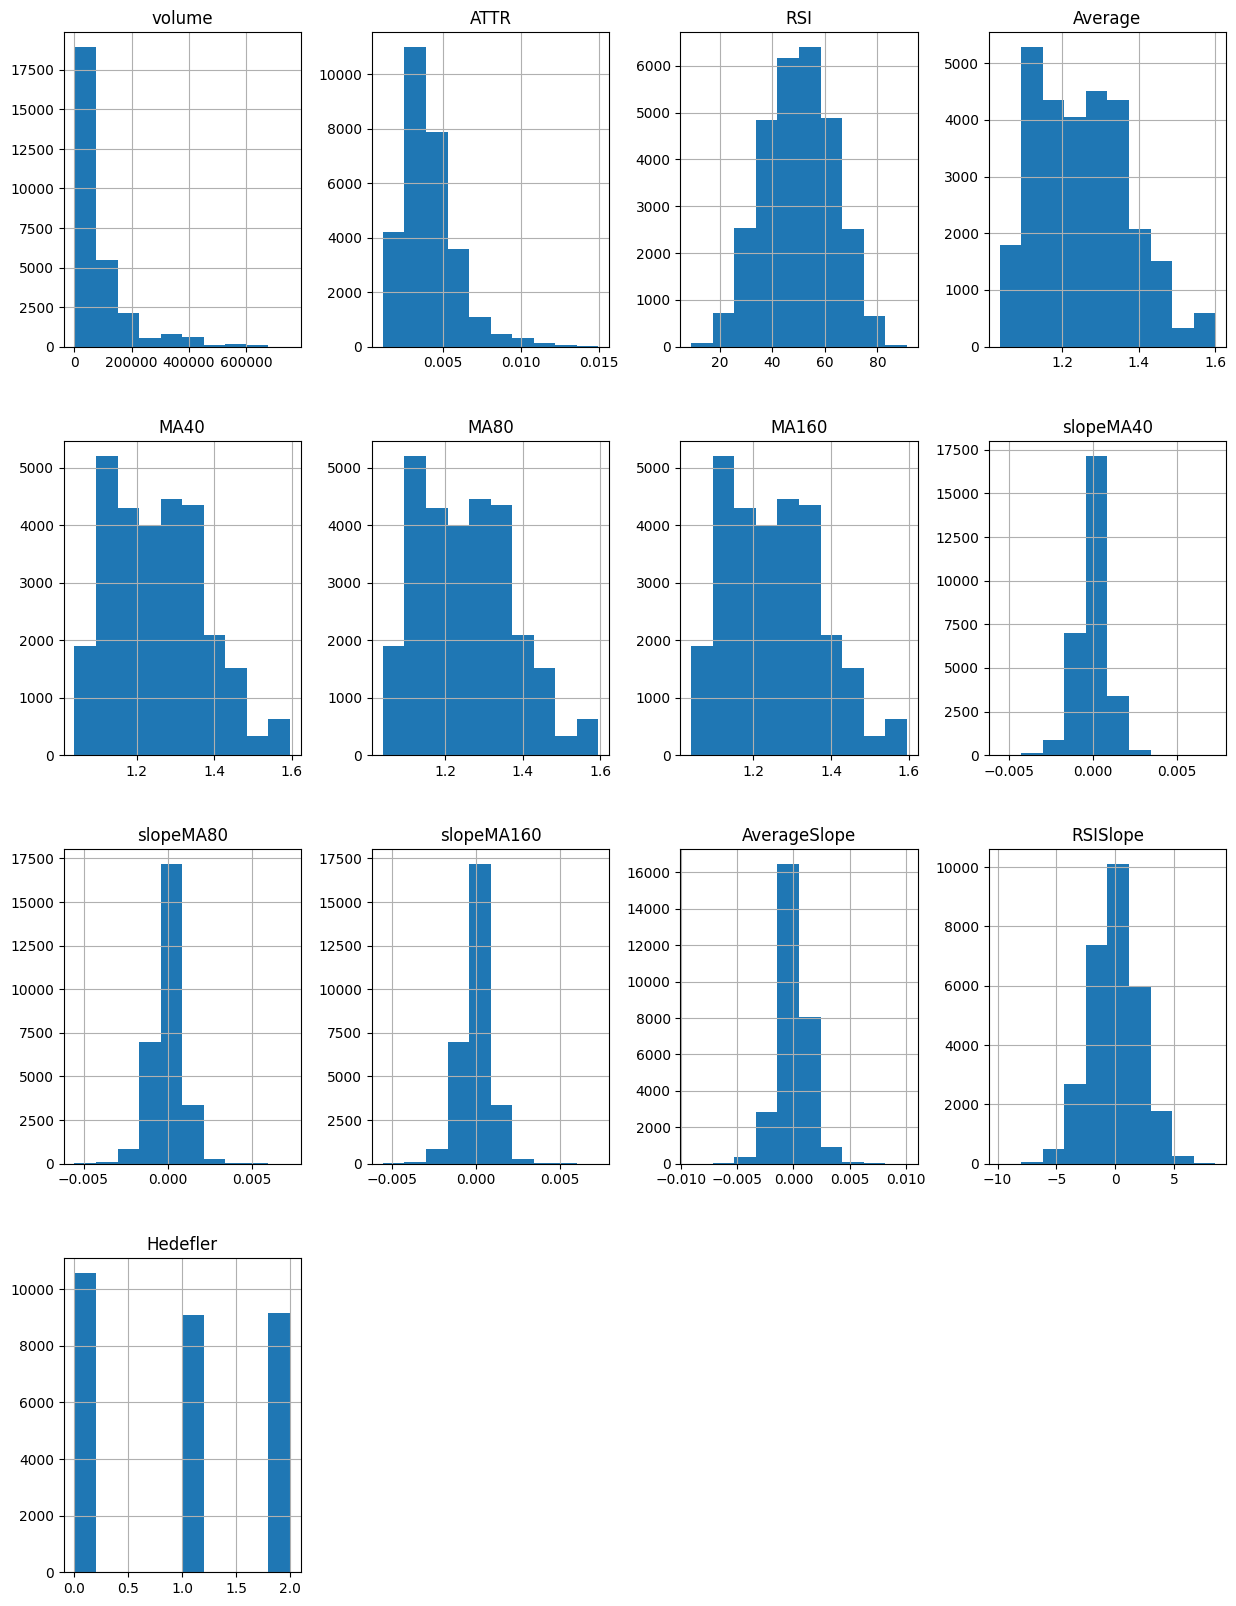

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 20))
ax = fig.gca()
deneme_model = deneme[['volume', 'ATTR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'Hedefler']]
deneme_model.hist(ax=ax)
plt.show()

Relative Strength Index`i Indicator Olarak Kullanma

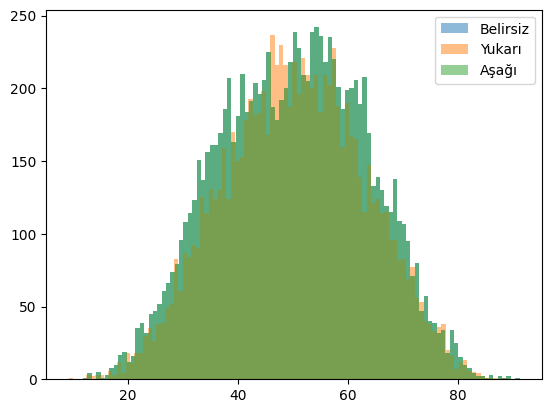

In [11]:
deneme_up = deneme.RSI[deneme['Hedefler'] == 2]
deneme_down = deneme.RSI[deneme['Hedefler'] == 1]
deneme_unclear = deneme.RSI[ deneme['Hedefler'] == 0 ]

plt.hist(deneme_unclear, bins=100,  alpha=0.5, label='Belirsiz')
plt.hist(deneme_up, bins=100,  alpha=0.5, label='Yukarı')
plt.hist(deneme_unclear, bins=100,  alpha=0.5, label='Aşağı')

plt.legend(loc='upper right')
plt.show()

In [12]:
deneme_model = deneme_model.dropna()

attributes = ['volume', 'ATTR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
x = deneme_model[attributes]
y = deneme_model['Hedefler']

print(x)

            volume      ATTR        RSI   Average      MA40      MA80  \
20      89533.6016  0.004754  52.234314  1.132190  1.138179  1.138179   
21      91527.1992  0.005232  65.989197  1.137890  1.138145  1.138145   
22     313726.1035  0.005300  67.990101  1.145475  1.138411  1.138411   
23     373156.8946  0.005335  72.152546  1.148030  1.139246  1.139246   
24      95166.0000  0.005404  73.217528  1.150480  1.140415  1.140415   
...            ...       ...        ...       ...       ...       ...   
28837    3638.3400  0.001848  42.935233  1.155445  1.156434  1.156434   
28838   10133.1300  0.001830  46.375154  1.156295  1.156411  1.156411   
28839   13688.2400  0.001907  37.631843  1.155025  1.156059  1.156059   
28840   18731.2700  0.001937  33.174435  1.153790  1.155594  1.155594   
28841    6749.2700  0.001894  34.656247  1.152975  1.155175  1.155175   

          MA160  slopeMA40  slopeMA80  slopeMA160  AverageSlope  RSISlope  
20     1.138179   0.000228   0.000228    0.0002

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200)
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Accuracy_train: %.2f%%" % (accuracy_train*100))
print("Accuracy_test: %.2f%%" % (accuracy_test*100))

Accuracy_train: 37.75%
Accuracy_test: 34.33%


Doğruluğu Nasıl Tahmin Etmeliyiz

In [16]:
print(deneme_model['Hedefler'].value_counts()*100/deneme_model['Hedefler'].count())

#Random Modelde Test Etme Kumar?

pred_test = np.random.choice([0,1,2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Hedefler
0.0    36.716688
2.0    31.759761
1.0    31.523551
Name: count, dtype: float64
Accuracy Gambler: 32.74%


Rastgelenin %2 yukarısındayız Kayda Değer bir Oran :)

XGB BOOST ile güçlendirme yapalım

In [17]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(x_train, y_train)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("Geliştirme Sonuçları")
print("Accuracy Train: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy Test: {:.4%}".format(acc_test))

Geliştirme Sonuçları
Accuracy Train: 78.1155%
****Test Results****
Accuracy Test: 41.4901%


Kayda değer bir şekilde doğruluk oranını artırdık

Şimdi Train Veri Setini Test Veri Setini Rastgele Seçmeyelim

In [18]:
train_index = int(0.8 * len(x))
x_train, x_test = x[:train_index], x[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(x_train, y_train)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("Geliştirme Sonuçları")
print("Accuracy Train: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy Test: {:.4%}".format(acc_test))

Geliştirme Sonuçları
Accuracy Train: 79.1316%
****Test Results****
Accuracy Test: 32.1813%


Geliştirdiğimiz Modeller İçin En Önemli Featureları Görelim

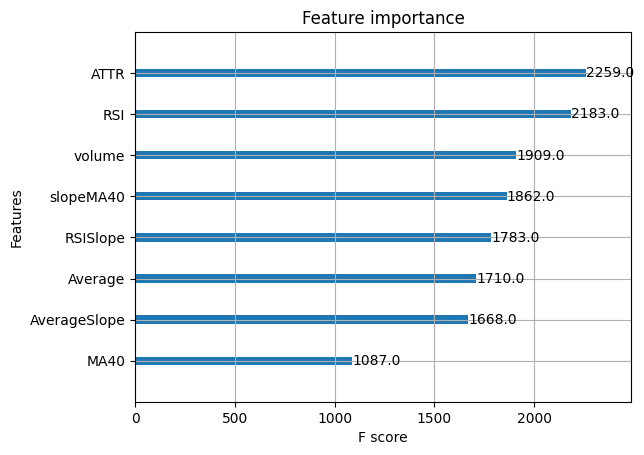

In [19]:
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model)
pyplot.show()

Modelimizi Otomatikleştirelim

In [20]:
import joblib

filename = 'mymodel1.sav'
joblib.dump(model, filename)

['mymodel1.sav']

Modelimizi Yükleyelim

In [21]:
loaded_model = joblib.load('mymodel1.sav')

Emirleri Email İle Telefonumuza Getirelim

In [22]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails

import smtplib

In [23]:
gmail_user = 'cengcemberk@gmail.com'
gmail_password = 'cemberk888.'
sent_from = gmail_user
to = ['cengcemberk@gmail.com']
subject = 'Trading Bot'